In [1]:
from datetime import datetime
from concurrent import futures
import pandas as pd
from pandas import DataFrame
import pandas_datareader.data as web
def download_stock(stock):
	""" try to query the iex for a stock, if failed note with print """
	try:
		print(stock)
		stock_df = web.DataReader(stock,'yahoo', start_time, now_time)
		stock_df['Name'] = stock
		output_name = stock + '_data.csv'
		stock_df.to_csv(output_name)
	except:
		bad_names.append(stock)
		print('bad: %s' % (stock))
if __name__ == '__main__':
	""" set the download window """
	now_time = datetime.now()
	start_time = datetime(now_time.year - 5, now_time.month , now_time.day)
	""" list of s_anp_p companies """
	s_and_p = ['^IXIC']
		
	bad_names =[] #to keep track of failed queries
	"""here we use the concurrent.futures module's ThreadPoolExecutor
		to speed up the downloads buy doing them in parallel
		as opposed to sequentially """
	#set the maximum thread number
	max_workers = 50
	workers = min(max_workers, len(s_and_p)) #in case a smaller number of stocks than threads was passed in
	with futures.ThreadPoolExecutor(workers) as executor:
		res = executor.map(download_stock, s_and_p)
	
	""" Save failed queries to a text file to retry """
	if len(bad_names) > 0:
		with open('failed_queries.txt','w') as outfile:
			for name in bad_names:
				outfile.write(name+'\n')
	#timing:
	finish_time = datetime.now()
	duration = finish_time - now_time
	minutes, seconds = divmod(duration.seconds, 60)
	print('getSandP_threaded.py')
	print(f'The threaded script took {minutes} minutes and {seconds} seconds to run.')
	#The threaded script took 0 minutes and 31 seconds to run.

^IXIC
getSandP_threaded.py
The threaded script took 0 minutes and 1 seconds to run.


In [2]:
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools
#from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import os, sys
path_add = os.path.abspath(os.pardir)
if path_add not in sys.path:
    sys.path.append(path_add)

%matplotlib inline

In [3]:
df = pd.read_csv('^IXIC_data.csv')
df

,Date,High,Low,Open,Close,Volume,Adj Close,Name
0,2016-08-08,5228.399902,5202.180176,5223.540039,5213.140137,1624450000,5213.140137,^IXIC
1,2016-08-09,5238.540039,5214.950195,5216.209961,5225.479980,1664320000,5225.479980,^IXIC
2,2016-08-10,5227.959961,5193.799805,5227.950195,5204.580078,1651240000,5204.580078,^IXIC
3,2016-08-11,5235.290039,5211.250000,5222.149902,5228.399902,1511670000,5228.399902,^IXIC
4,2016-08-12,5233.339844,5215.549805,5219.660156,5232.890137,1501620000,5232.890137,^IXIC
...,...,...,...,...,...,...,...,...
1254,2021-08-02,14770.410156,14665.669922,14758.599609,14681.070312,3738200000,14681.070312,^IXIC
1255,2021-08-03,14762.599609,14584.089844,14713.990234,14761.290039,4117520000,14761.290039,^IXIC
1256,2021-08-04,14812.370117,14734.120117,14747.209961,14780.530273,4319400000,14780.530273,^IXIC
1257,2021-08-05,14896.469727,14776.030273,14794.080078,14895.120117,4087320000,14895.120117,^IXIC


In [4]:
def clean(df, train_size):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df=df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Name'])
    cutoff = round(df.shape[0]*train_size)
    train = df[:cutoff]
    test = df[cutoff:]
    return train, test

In [5]:
IXIC_train, IXIC_test = clean(df, .7)

In [6]:
IXIC_test

,Close
Date,
2020-02-07,9520.509766
2020-02-10,9628.389648
2020-02-11,9638.940430
2020-02-12,9725.959961
2020-02-13,9711.969727
...,...
2021-08-02,14681.070312
2021-08-03,14761.290039
2021-08-04,14780.530273


In [7]:
IXIC_train

,Close
Date,
2016-08-08,5213.140137
2016-08-09,5225.479980
2016-08-10,5204.580078
2016-08-11,5228.399902
2016-08-12,5232.890137
...,...
2020-01-31,9150.940430
2020-02-03,9273.400391
2020-02-04,9467.969727


In [11]:
training_data = IXIC_train['Close'].values
test_data = IXIC_test['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))


Testing Mean Squared Error is 35234.89010415916


AttributeError: 'DataFrame' object has no attribute 'Date'

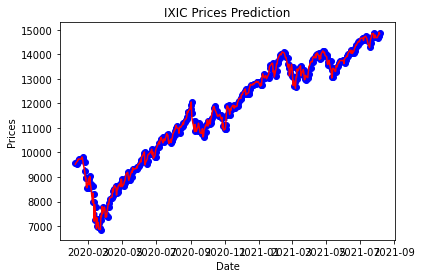

In [14]:
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('IXIC Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()
